# 1. Import Libraries

In [2]:
!pip install mplfinance > NUL 2>&1
!pip install pandas-ta  > NUL 2>&1

In [3]:
import numpy as np
import pandas as pd
import pandas_ta as ta
import matplotlib.pyplot as plt
import seaborn as sns
import mplfinance as mpf
from tqdm import tqdm

from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle

import torch
from torch import nn, optim
from torch.nn import functional
from torch.utils.data import TensorDataset, DataLoader

In [4]:
import warnings
warnings.filterwarnings("ignore")

# 2. Device Management

In [6]:
if torch.cuda.is_available():
    default_device = torch.device("cuda")
else:
    default_device = torch.device("cpu")

default_device

device(type='cuda')

In [7]:
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

# 3. Dataset Preparation

In [9]:
data = pd.read_csv('google_stock_data.csv')

In [10]:
data.head()

,Date,Close,High,Low,Open,Volume
0,NaN,GOOGL,GOOGL,GOOGL,GOOGL,GOOGL
1,2020-06-04,70.3785171508789,71.72309429138843,69.96599205492319,71.4971694316438,26982000
2,2020-06-05,71.65840148925781,71.9709103787135,70.0461071028752,70.44520002096422,42642000
3,2020-06-08,72.05748748779297,72.10525562528537,70.88509140875318,70.974667107052,33878000
4,2020-06-09,72.25852966308594,73.04079279119881,71.77484210279437,71.91816171630913,33624000


In [11]:
data.drop(0, axis=0, inplace=True)

data.reset_index(drop=True, inplace=True)

In [12]:
data.head()

,Date,Close,High,Low,Open,Volume
0,2020-06-04,70.3785171508789,71.72309429138843,69.96599205492319,71.4971694316438,26982000
1,2020-06-05,71.65840148925781,71.9709103787135,70.0461071028752,70.44520002096422,42642000
2,2020-06-08,72.05748748779297,72.10525562528537,70.88509140875318,70.974667107052,33878000
3,2020-06-09,72.25852966308594,73.04079279119881,71.77484210279437,71.91816171630913,33624000
4,2020-06-10,72.88652801513672,73.28810385800969,72.37198974644225,72.72778683921254,31762000


In [14]:
start_date = min(data['Date'])

end_date = max(data['Date'])

print(f"Data Range: {start_date} to {end_date}")

Data Range: 2020-06-04 to 2025-06-02


# 4. Preprocessing

## 4-1. Check Column Data Types

In [17]:
data.dtypes

Date      object
Close     object
High      object
Low       object
Open      object
Volume    object
dtype: object

In [18]:
data[["Close", "High", "Low", "Open"]] = data[["Close", "High", "Low", "Open"]].astype(float)

data[["Volume"]] = data[["Volume"]].astype(int)

In [19]:
data.dtypes

Date       object
Close     float64
High      float64
Low       float64
Open      float64
Volume      int32
dtype: object

## 4-2. Check Missing Values

In [21]:
data.isnull().sum()

Date      0
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64

<div class="alert alert-block alert-info">
<b>Number of Missing Values: </b>0
</div>

## 4-3. Check Noises

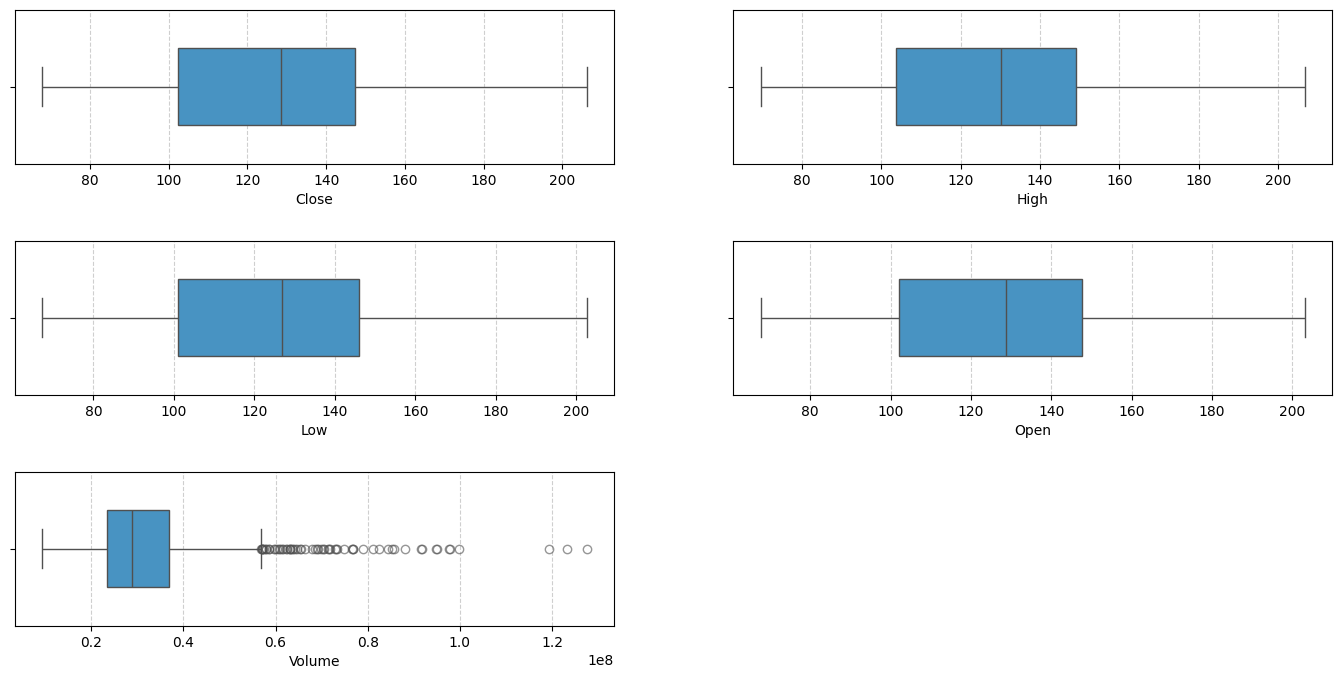

In [37]:
columns = ["Close", "High", "Low", "Open", "Volume"]

plt.figure(figsize = (17,8))

for i, column in enumerate(columns):
    
    plt.subplot(3,2,i+1)
    sns.boxplot(x = column,
                data = data,
                width = 0.5,
                color = '#3498D6',
                flierprops = {'alpha': 0.6})

    plt.grid(axis='x', linestyle='--', alpha=0.6)
    
plt.subplots_adjust(hspace = 0.5)      
plt.show()

<div class="alert alert-block alert-info">
<b>Number of Noises: </b>0<br/>
The data no noticeable noise.
</div>

## 4-4. Visualization

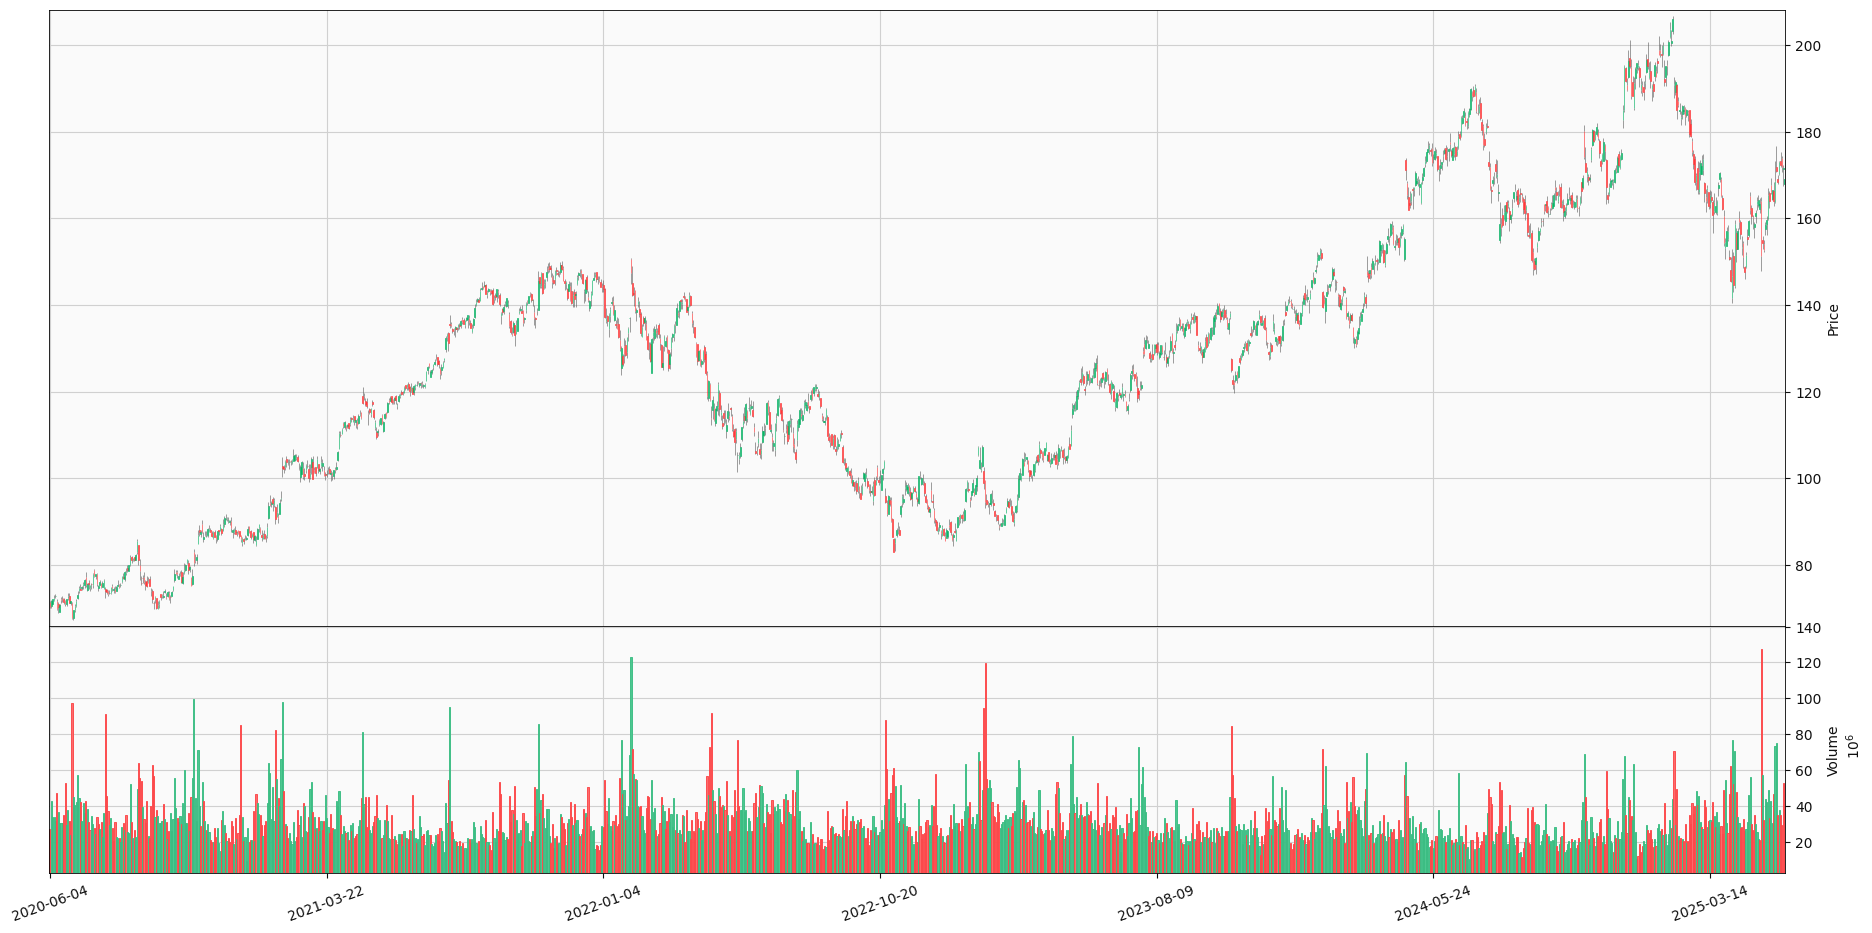

In [41]:
temp_df = data.copy()
temp_df["Date"] = pd.to_datetime(temp_df["Date"])
temp_df = temp_df.set_index("Date")

fig, axes = mpf.plot(
    temp_df,
    type='candle',
    volume=True,
    style='yahoo',
    ylabel='Price',
    ylabel_lower='Volume',
    figsize=(20, 10),
    datetime_format='%Y-%m-%d',
    xrotation=20,
    show_nontrading=False,
    returnfig=True,
    tight_layout=True
)

for ax in [axes[0], axes[2]]:
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(0.6)

plt.show()

## 4-5. Feature Engineering

In [43]:
# SMA
data["SMA_14"] = ta.sma(data["Close"], length=14)
data["SMA_26"] = ta.sma(data["Close"], length=26)
data["SMA_50"] = ta.sma(data["Close"], length=50)

# EMA
data["EMA_14"] = ta.ema(data["Close"], length=14)
data["EMA_26"] = ta.ema(data["Close"], length=26)
data["EMA_50"] = ta.ema(data["Close"], length=50)

# RSI
data["RSI_14"] = ta.rsi(data["Close"], length=14)
data["RSI_26"] = ta.rsi(data["Close"], length=26)
data["RSI_50"] = ta.rsi(data["Close"], length=50)

# Bollinger Bands (20 و 50 روزه)
bb14 = ta.bbands(data["Close"], length=14, std=2)
bb26 = ta.bbands(data["Close"], length=26, std=2)
bb50 = ta.bbands(data["Close"], length=50, std=2)
data = pd.concat([data, bb14, bb26, bb50], axis=1)

In [46]:
data.drop('Date', axis=1, inplace=True)

data.dropna(inplace=True)

data.reset_index(drop=True, inplace=True)

In [48]:
data.head()

,Close,High,Low,Open,Volume,SMA_14,SMA_26,SMA_50,EMA_14,EMA_26,...,BBL_26_2.0,BBM_26_2.0,BBU_26_2.0,BBB_26_2.0,BBP_26_2.0,BBL_50_2.0,BBM_50_2.0,BBU_50_2.0,BBB_50_2.0,BBP_50_2.0
0,74.873535,75.627932,74.593373,75.320396,21942000,74.635423,75.327519,73.693386,74.769403,74.542710,...,72.937008,75.327519,77.718031,6.346981,0.405045,69.180274,73.693386,78.206499,12.248352,0.630747
1,75.451271,75.826484,74.891949,75.437839,19990000,74.680174,75.283939,73.769244,74.860319,74.610010,...,72.945931,75.283939,77.621947,6.211174,0.535785,69.268012,73.769244,78.270476,12.203546,0.686841
2,77.418869,77.497989,75.721486,75.942924,28378000,74.794876,75.367290,73.876471,75.201459,74.818074,...,72.889478,75.367290,77.845103,6.575298,0.913990,69.288850,73.876471,78.464093,12.419709,0.886082
3,76.863029,78.069762,76.633627,77.255152,30472000,74.817055,75.412747,73.968561,75.423002,74.969552,...,72.871031,75.412747,77.954463,6.740813,0.785296,69.329974,73.968561,78.607149,12.542050,0.811999
4,78.437492,78.632559,76.357934,76.632121,26382000,75.130912,75.526376,74.079581,75.824934,75.226437,...,72.730761,75.526376,78.321991,7.403017,1.020658,69.286749,74.079581,78.872412,12.939683,0.954628


<div class="alert alert-block alert-info">
<b>24 new features</b> from <b>technical indicators</b> have been <b>added</b> to the <b>data</b>.
</div>

## 4-6. Input–Output Sequence Creation

In [60]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_data = scaler.fit_transform(data)

In [62]:
x, y = [], []
lookback = 50
forecast = 10

for i in range(lookback, len(scaled_data) - forecast):
    x.append(scaled_data[i - lookback:i])
    y.append(scaled_data[i:i + forecast, 0])

In [64]:
x = np.array(x)

y = np.array(y)
y = y.reshape((y.shape[0], 10, 1))

<div class="alert alert-block alert-info">
Data is <b>scaled</b> with <b>MinMaxScaler</b>.<br/>
Sequences of <b>50 past days</b> are used to predict the <b>next 10 days</b> of <b>close price</b>. <br/>
Converted to NumPy arrays for modeling.
</div>

## 4-7. Data Partitioning

In [68]:
# 5% for Test
x_test, y_test = x[-58:], y[-58:]

# 95% for Train and Validation
x_train_val, y_train_val = x[:-58], y[:-58]

In [70]:
x_train_val_shuffled, y_train_val_shuffled = shuffle(x_train_val, y_train_val, random_state=42)

# 90% for Train
x_train, y_train = x_train_val_shuffled[:-58], y_train_val_shuffled[:-58]

# 5% for Validation
x_val, y_val = x_train_val_shuffled[-58:], y_train_val_shuffled[-58:]

In [72]:
y_train = y_train.reshape((y_train.shape[0], 10, 1))
y_val   = y_val  .reshape((y_val.shape[0],   10, 1))
y_test  = y_test .reshape((y_test.shape[0],  10, 1))

In [74]:
print(f'Number of Train Data: {len(x_train)}')
print(f'Number of Validation Data: {len(x_val)}')
print(f'Number of Test Data: {len(x_test)}')

Number of Train Data: 1029
Number of Validation Data: 58
Number of Test Data: 58


<div class="alert alert-block alert-info">
<b>5%</b> of the last data was used for <b>testing</b>.<br/>
The remaining <b>95%</b> was allocated for <b>training</b> and <b>validation</b>.<br/>
Then, after <b>shuffling</b>, <b>90%</b> of the total data was used for <b>training</b> and <b>5%</b> for <b>validation</b>.
</div>

## 4-8. Create Data Loaders

In [86]:
batch_size = 32

In [88]:
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

x_val_tensor = torch.tensor(x_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [90]:
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset   = TensorDataset(x_val_tensor,   y_val_tensor)
test_dataset  = TensorDataset(x_test_tensor,  y_test_tensor)

In [115]:
class DeviceDataLoader:
    
    def __init__(self, dataloader, device):
        self.dataloader = dataloader
        self.device = device

    def __iter__(self):
        for batch in self.dataloader:
            yield to_device(batch, self.device)

    def __len__(self):
        return len(self.dataloader)

In [117]:
train_loader = DeviceDataLoader(
    DataLoader(train_dataset, batch_size = batch_size), 
    default_device
)

val_loader = DeviceDataLoader(
    DataLoader(val_dataset, batch_size = batch_size), 
    default_device
)

test_loader = DeviceDataLoader(
    DataLoader(test_dataset, batch_size = batch_size), 
    default_device
)

# 5. Modeling

## 5-1. Build Model

In [265]:
def process_batch(model, batch, detach_loss=False):
    
    seq_in, seq_out = batch
    outputs = model(seq_in)
    
    loss = functional.l1_loss(outputs, seq_out)
    if detach_loss:
        loss = loss.detach() 
        
    return loss

In [496]:
# The model is based on an LSTM Encoder–Decoder architecture.

class Model(nn.Module):
    
    def __init__(self, timesteps_in, timesteps_out, n_features):
        super().__init__()
        
        # Encoder
        self.encoder_lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=256,
            batch_first=True
        )
        
        # Decoder
        self.decoder_input = nn.Linear(256, 256)
        self.repeat_vector = timesteps_out
        self.decoder_lstm = nn.LSTM(
            input_size=256,
            hidden_size=256,
            batch_first=True
        )
        self.fc = nn.Linear(256, 1)

    
    def forward(self, x):
        
        # Encoder
        _, (h, c) = self.encoder_lstm(x)
        h = h[-1]

        # Repeat vector functionality
        repeated = h.unsqueeze(1).repeat(1, self.repeat_vector, 1)

        # Decoder
        decoder_out, _ = self.decoder_lstm(repeated, (h.unsqueeze(0), c))
        output = self.fc(decoder_out)

        return output


    def fit(self, epochs, opt_func, max_lr, train_loader, val_loader):

        torch.cuda.empty_cache()
        optimizer = opt_func(model.parameters(), max_lr)
        sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))

        epoch_groups = [(s, min(s + 99, epochs)) for s in range(1, epochs+1, 100)]
        self.history = []

        for start, end in epoch_groups:

            report = {}
            report['Epoch'] = f"{start}-{end} / {epochs}"
            print(f"Epoch: {report['Epoch']}")

            # Training
            for epoch in tqdm(range(end - start + 1), desc="Training Epochs"):
                self.train()
                train_losses = []
                for batch in train_loader:
                    loss = process_batch(self, batch, detach_loss=False)
                    loss.backward()
                    optimizer.step()
                    optimizer.zero_grad()
                    sched.step()
                    train_losses.append(loss)

            # Validation
            self.eval()
            val_losses = []
            for batch in val_loader:
                loss = process_batch(self, batch, detach_loss=True)
                val_losses.append(loss)

            report['train_loss'] = torch.stack(train_losses).mean().item()
            report['val_loss'] = torch.stack(val_losses).mean().item()
            print(f"Loss: {report['train_loss']:.4f} | Validation Loss: {report['val_loss']:.4f}\n")
            self.history.append(report)

    
    def evaluate(self, test_loader):
        
        self.eval()
        test_losses = []
        for batch in tqdm(test_loader, desc="Test Batches"):
            loss = process_batch(self, batch, detach_loss=True)
            test_losses.append(loss)
        test_loss = torch.stack(test_losses).mean().item()
        
        return test_loss

    
    def set_device(self, device):
        self = to_device(self, device)

In [498]:
timesteps_in = 50
timesteps_out = 10
n_features = x_train.shape[2]

model = Model(timesteps_in, timesteps_out, n_features)

In [500]:
model.set_device(default_device)

## 5-2. Model Training

In [503]:
epochs = 1000
optimizer = optim.NAdam
max_lr = 0.001

In [505]:
model.fit(epochs, optimizer, max_lr, train_loader, val_loader)

Epoch: 1-100 / 1000


Training Epochs: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:44<00:00,  2.25it/s]


Loss: 0.0378 | Validation Loss: 0.0399

Epoch: 101-200 / 1000


Training Epochs: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:43<00:00,  2.32it/s]


Loss: 0.0212 | Validation Loss: 0.0262

Epoch: 201-300 / 1000


Training Epochs: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:43<00:00,  2.31it/s]


Loss: 0.0148 | Validation Loss: 0.0179

Epoch: 301-400 / 1000


Training Epochs: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:45<00:00,  2.20it/s]


Loss: 0.0093 | Validation Loss: 0.0141

Epoch: 401-500 / 1000


Training Epochs: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:53<00:00,  1.86it/s]


Loss: 0.0057 | Validation Loss: 0.0108

Epoch: 501-600 / 1000


Training Epochs: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:43<00:00,  2.30it/s]


Loss: 0.0038 | Validation Loss: 0.0097

Epoch: 601-700 / 1000


Training Epochs: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:44<00:00,  2.25it/s]


Loss: 0.0024 | Validation Loss: 0.0085

Epoch: 701-800 / 1000


Training Epochs: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:45<00:00,  2.21it/s]


Loss: 0.0015 | Validation Loss: 0.0074

Epoch: 801-900 / 1000


Training Epochs: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:43<00:00,  2.27it/s]


Loss: 0.0006 | Validation Loss: 0.0070

Epoch: 901-1000 / 1000


Training Epochs: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:44<00:00,  2.26it/s]

Loss: 0.0004 | Validation Loss: 0.0070



## 5-3. Loss Analysis

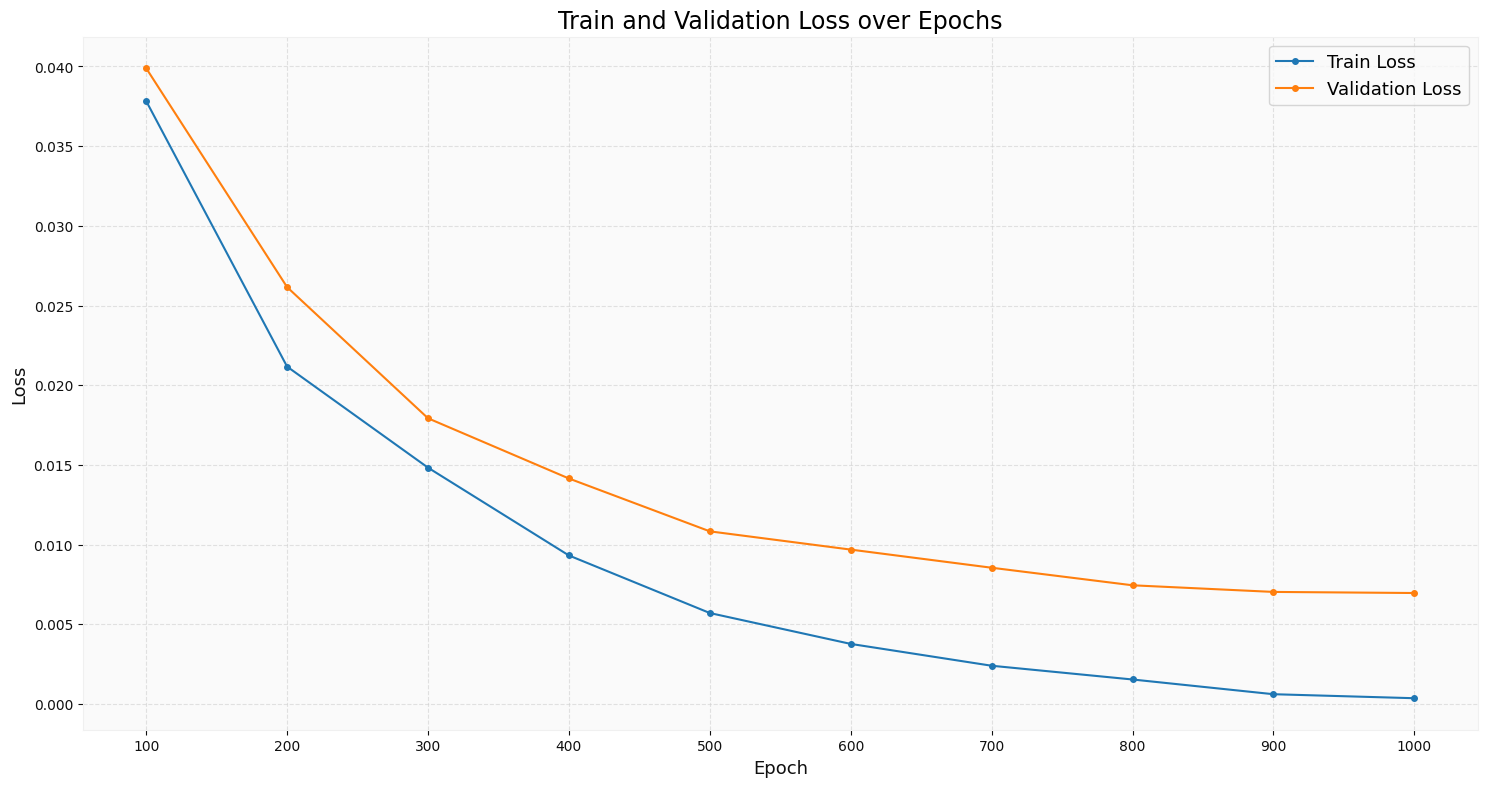

In [538]:
train_losses = [value["train_loss"] for value in model.history]
val_losses = [value["val_loss"] for value in model.history]
range_x = [min(s + 99, epochs) for s in range(1, epochs+1, 100)]

plt.figure(figsize=(18, 9))
plt.plot(range_x, train_losses, label='Train Loss', marker='o', markersize=4)
plt.plot(range_x, val_losses, label='Validation Loss', marker='o', markersize=4)
plt.title("Train and Validation Loss over Epochs", fontsize=17)
plt.xlabel("Epoch", fontsize=13)
plt.ylabel("Loss", fontsize=13)
plt.xticks(range_x)
plt.legend(fontsize=13)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

## 5-4. Evaluate Model on Test Data

In [541]:
test_loss = model.evaluate(test_loader)

Test Batches: 100%|█████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 182.06it/s]


In [543]:
print("Test Loss:", test_loss)

Test Loss: 0.08875101059675217


# 6. Visualization of Predicted and Real Prices

In [546]:
def inverse_close(values):
    rescaled_values = []
    for value in values:
        rescaled_value = (min(data['Close']) + ((value[0] + 1) / 2) *  (max(data['Close']) - min(data['Close'])))
        rescaled_values.append(rescaled_value)
    return rescaled_values

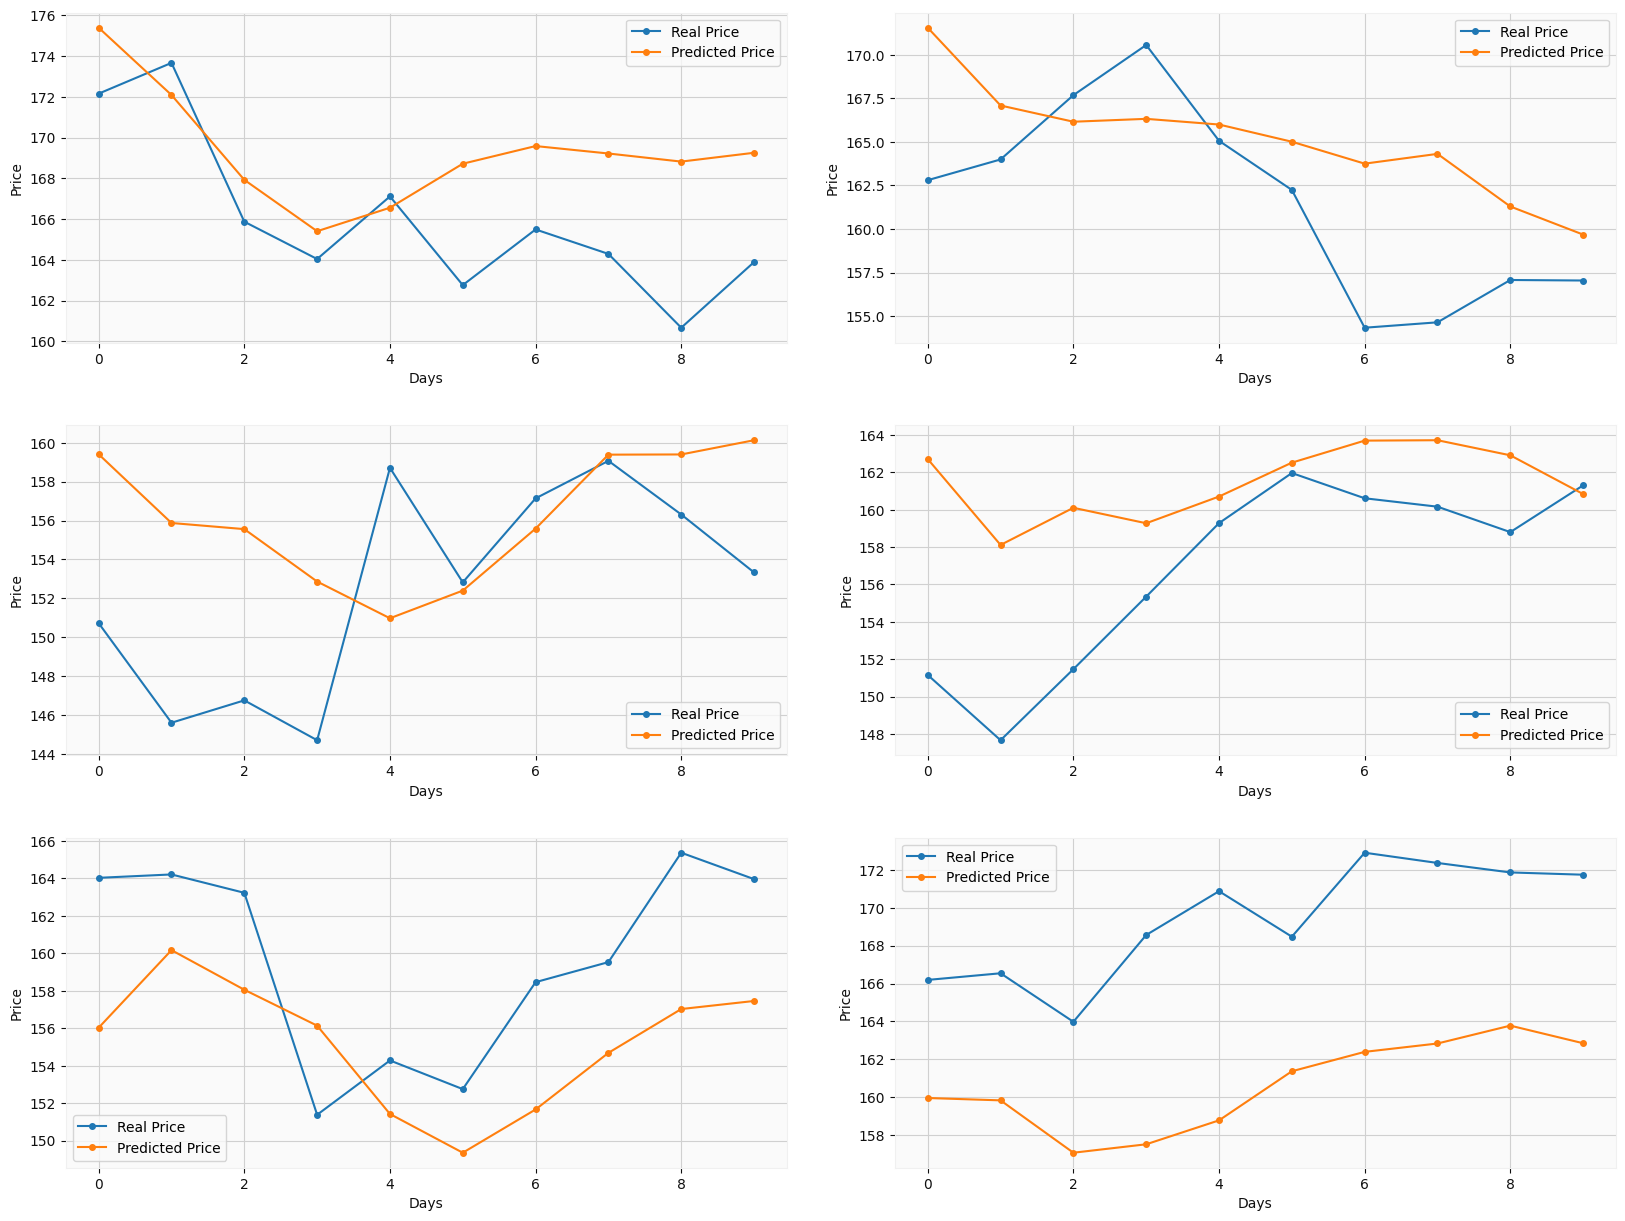

In [548]:
selected_indices = range(7, len(x_test), 10)

plt.figure(figsize=(20, 15))

for i, idx in enumerate(selected_indices):
    
    real = y_test[idx].reshape(-1, 1)
    
    x_input = torch.tensor(x_test[idx], dtype=torch.float32).unsqueeze(0).to(default_device)
    pred = model(x_input)
    pred = pred.squeeze(0).detach().cpu().numpy().reshape(-1, 1)

    real_rescaled = inverse_close(real)
    pred_rescaled = inverse_close(pred)

    plt.subplot(3, 2, i + 1)
    plt.plot(range(10), real_rescaled, marker='o', markersize=4, label="Real Price")
    plt.plot(range(10), pred_rescaled, marker='o', markersize=4, label="Predicted Price")
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.legend()

plt.subplots_adjust(hspace=0.25, wspace=0.15)    
plt.show()